In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs               
import cartopy.feature as cfeature         
import cartopy.util as cutil
import xarray as xr                        
import numpy as np 
import pandas as pd
import plotting_module
import xesmf as xe

In [2]:
ozone_dataset = xr.open_dataset("/glade/campaign/acom/acom-climate/UTLS/shawnh/archive/FCnudged_f09.mam.mar27.2000_2021.002/atm/proc/tseries/month_1/FCnudged_f09.mam.mar27.2000_2021.002.cam.h0.O3.200201-202412.nc")
pdeldry_dataset = xr.open_dataset("/glade/campaign/acom/acom-climate/UTLS/shawnh/archive/FCnudged_f09.mam.mar27.2000_2021.002/atm/proc/tseries/month_1/FCnudged_f09.mam.mar27.2000_2021.002.cam.h0.PDELDRY.200201-202412.nc")
ps_dataset = xr.open_dataset('/glade/campaign/acom/acom-climate/UTLS/shawnh/archive/FCnudged_f09.mam.mar27.2000_2021.002/atm/proc/tseries/month_1/FCnudged_f09.mam.mar27.2000_2021.002.cam.h0.PS.200201-202412.nc')

In [3]:
ozone = ozone_dataset["O3"]
lat = ozone.coords['lat']
lon = ozone.coords['lon']

Calculating pressure at every hybrid level

p(k) = a(k) * p0 + b(k) * ps

In [4]:
p0 = ozone_dataset["P0"]
hyai = ozone_dataset["hyai"]
hybi = ozone_dataset["hybi"]
ps = ps_dataset['PS']
lev = ozone_dataset.coords['lev']
num_lev = lev.shape[0]
pdeldry = pdeldry_dataset['PDELDRY']

# convert to hPa from Pa
pdeldry = pdeldry.copy() / 100 

# truncate to levels 16-31
truncated_pdeldry = pdeldry.isel({pdeldry.dims[1]: slice(16, 31)})
truncated_ozone = ozone.isel({ozone.dims[1]: slice(16, 31)})

Now changing 'ozone' and 'pdeldry' DataArrays into grouped by months one, just to see what it looks like as a plot for the 12 months.

In [5]:
start_date = '2005-02-01'

# group the 240 month dates based on calendar months for both PDELDRY and O3 variables

truncated_pdeldry = truncated_pdeldry.sel(time=slice(start_date,'2025-01-01'))
pdeldry_monthly_mean = truncated_pdeldry.groupby('time.month').mean('time')

truncated_ozone = truncated_ozone.sel(time=slice(start_date,'2025-01-01'))
ozone_monthly_mean = truncated_ozone.groupby('time.month').mean('time')

In [6]:
# constants / conversion factor
NAv = 6.0221415e+23                       # molecules in mole
g = 9.81                                  # gravity
MWair = 28.94                             # g/mol
xp_const = (NAv * 10)/(MWair*g)           # scaling factor, pa to hPa and cm to m
DU_CONVERSION = 2.69 * 10**16

In [7]:
#mod_press thing

In [8]:
ozone_column = xr.dot(pdeldry_monthly_mean, xp_const*ozone_monthly_mean, dims='lev')
ozone_column_seasonal = xr.dot(truncated_pdeldry, xp_const*truncated_ozone, dims='lev')
# calculate pdeldry with hybrid pressure levels, should be same
#check pn > 300 hpa
# |Pn - 300| = delta p
# if 300 - 250hpa (in upper) is negative: then there is an error, 300 somewhere up in the atmosphere

# figure out where 300 hPa

In [9]:
ozone_du_column = ozone_column.copy() / DU_CONVERSION
ozone_du_column_seasonal = ozone_column_seasonal.copy() / DU_CONVERSION

# average over months from 2005-2024, find highest level interfaces (16-31)

In [10]:
omi_mls_ds = xr.open_dataarray("/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_300hpa_monthly_mean_2005_2024.nc")
omi_mls_ds = omi_mls_ds.rename({'latitude': 'lat', 'longitude': 'lon'})

# shifting lon to be 0-360
omi_mls_ds['lon'] = omi_mls_ds['lon'] % 360
omi_mls_ds = omi_mls_ds.sortby('lon')

In [11]:
ozone_du_column_regridded = ozone_du_column.interp(coords=dict(lat=omi_mls_ds.lat, lon=omi_mls_ds.lon), method='linear')
ozone_du_column_seasonal_regridded = ozone_du_column_seasonal.interp(coords=dict(lat=omi_mls_ds.lat, lon=omi_mls_ds.lon), method='linear')

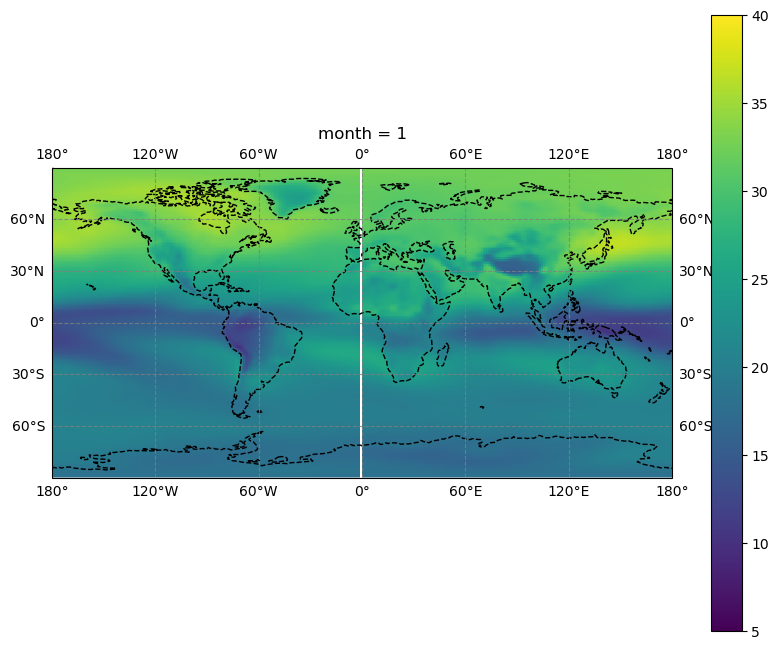

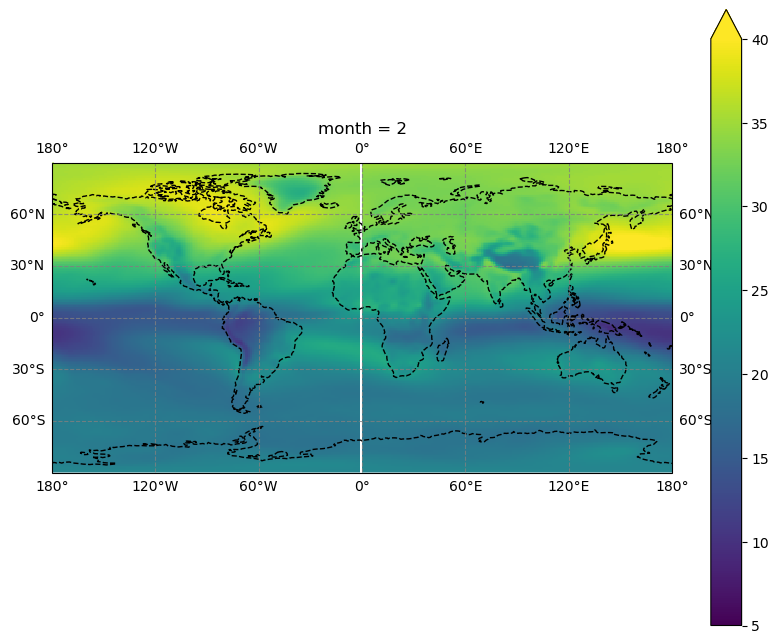

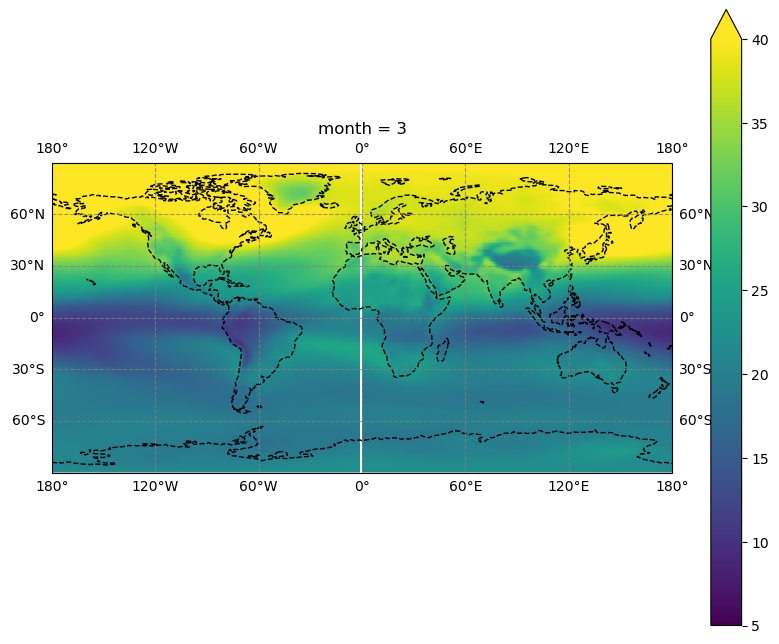

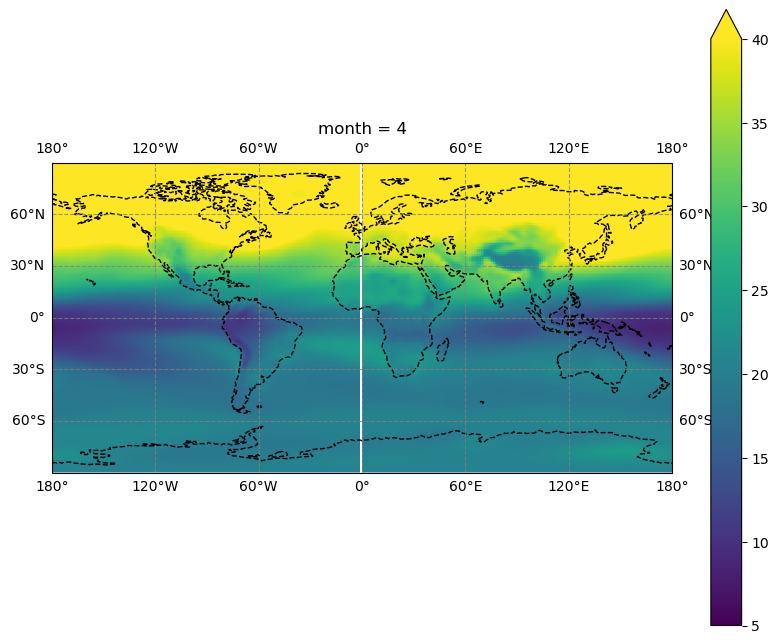

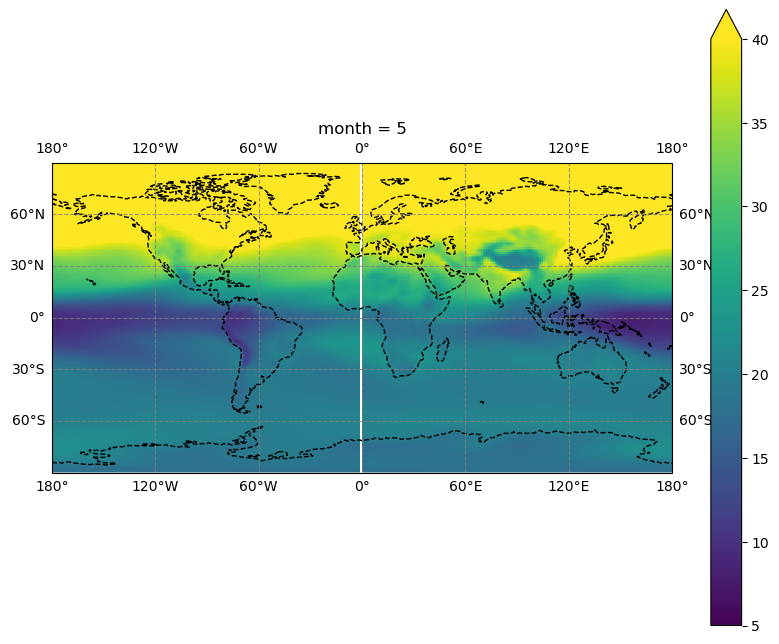

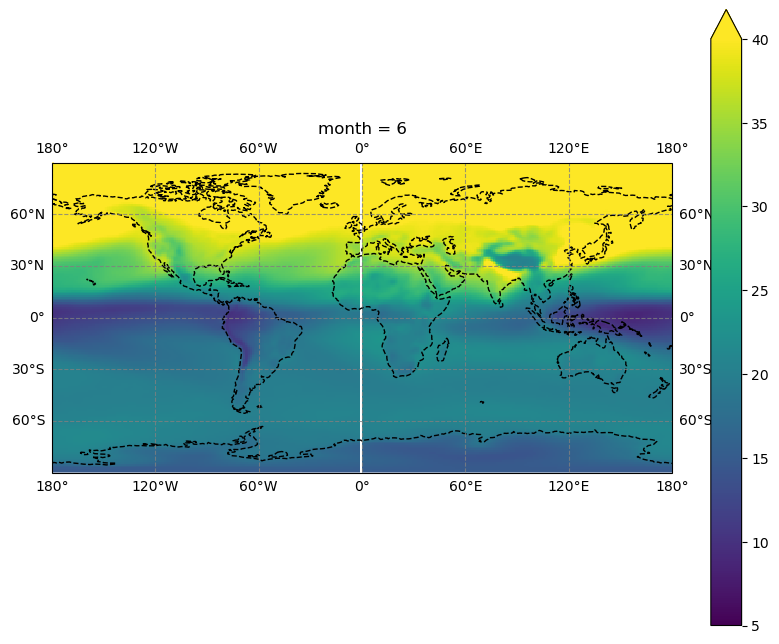

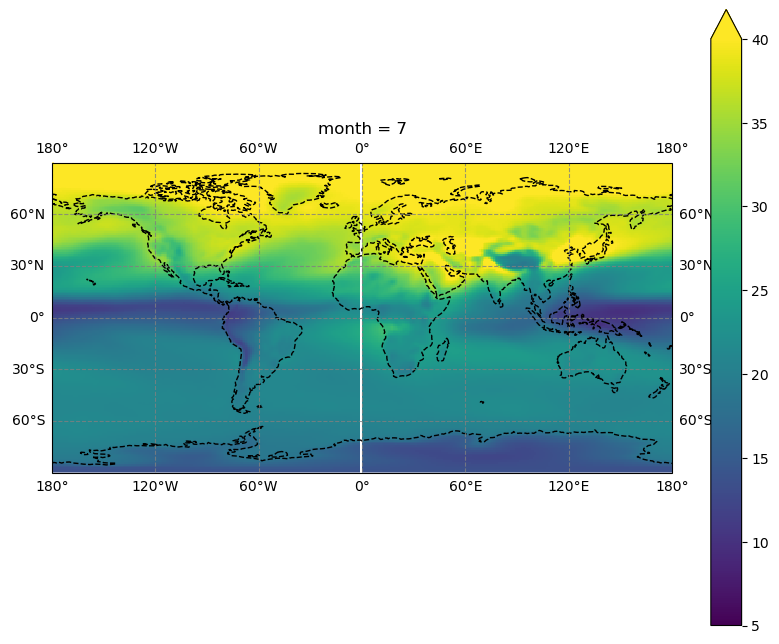

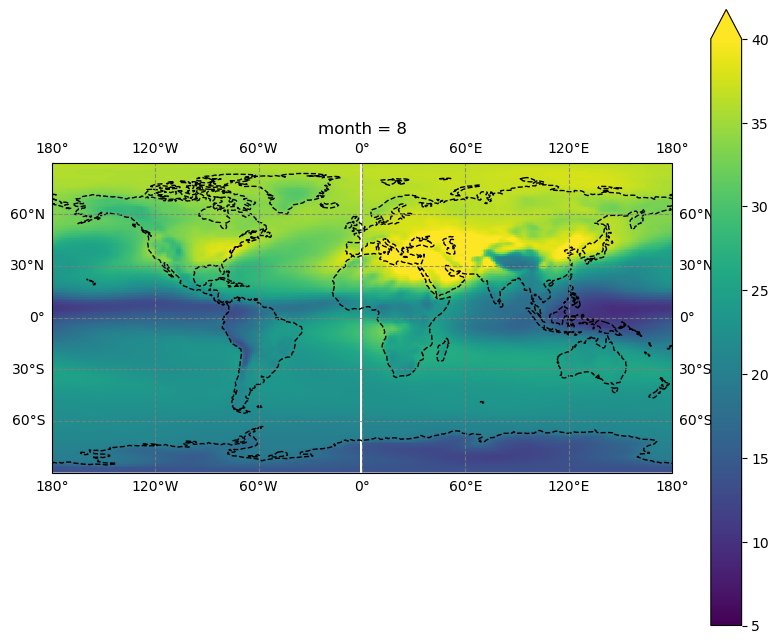

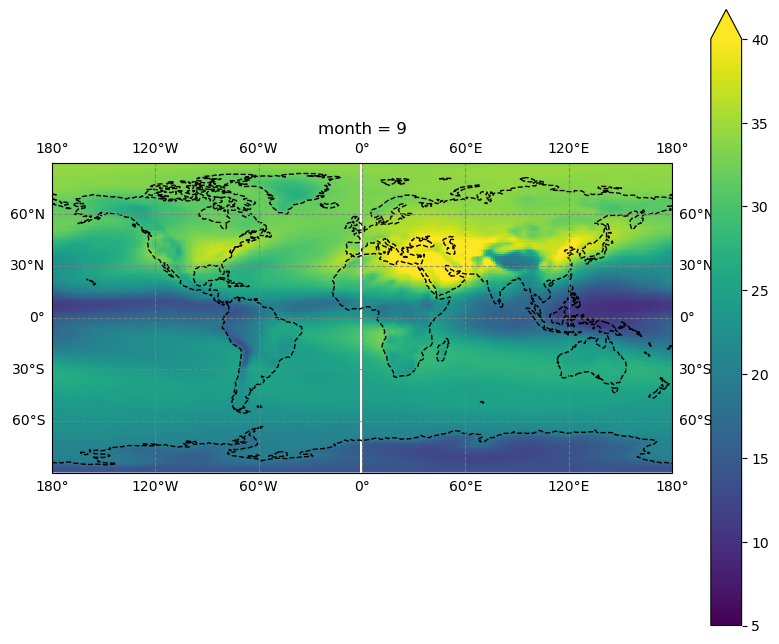

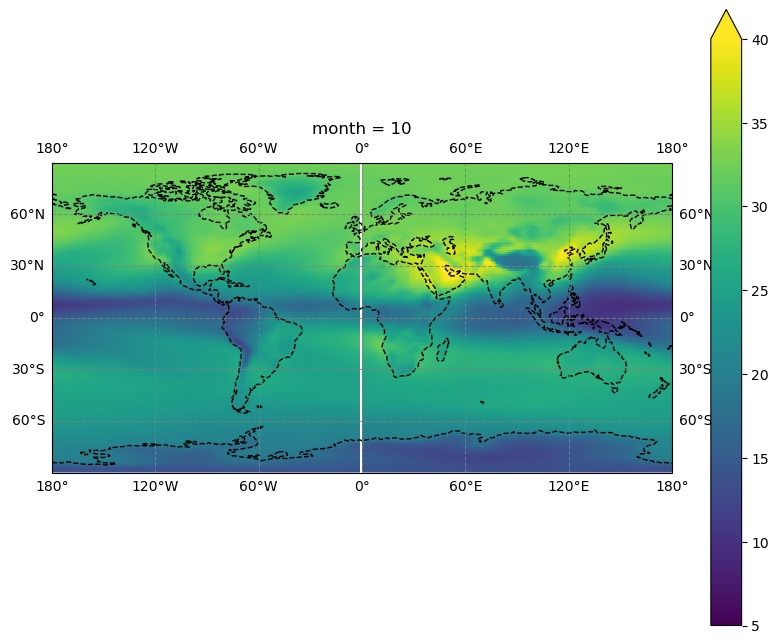

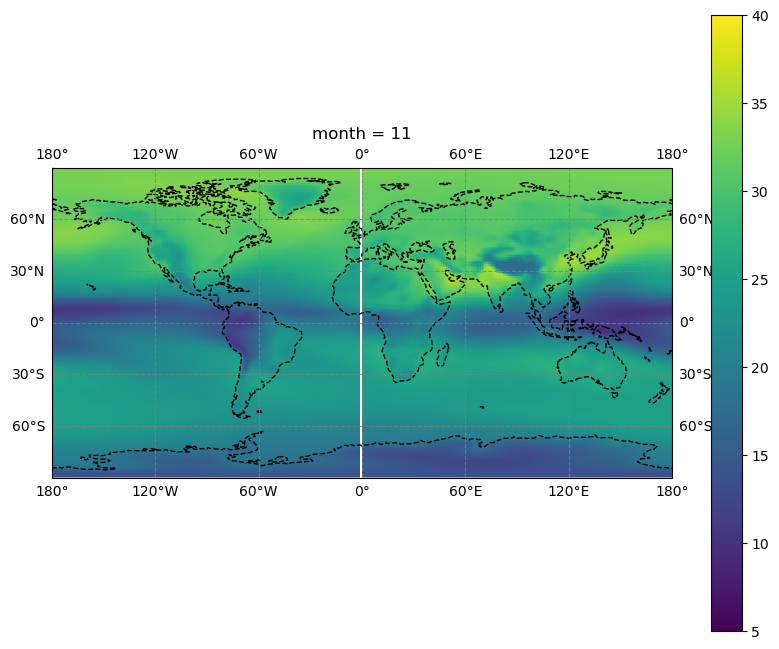

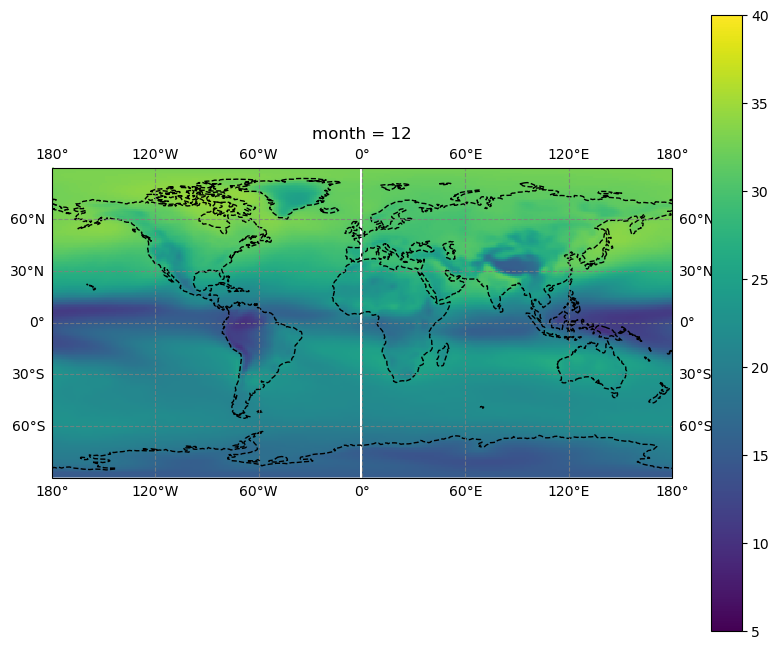

In [12]:
ozone_du_column_regridded
for i in range(12):
    month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


    plt.figure(figsize=(10,8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # add coastlines
    ax.add_feature(cfeature.COASTLINE, linestyle='--')

    # add lat lon grids
    gl = ax.gridlines(draw_labels=True, color='grey', alpha=0.8, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

    plt.title("CESM Tropospheric Ozone for " + month_list[i],fontsize=18)

    # plotting data
    ozone_du_column_regridded[i].plot(vmin=5, vmax=40)
    plt.show()

In [13]:
# adding a cyclic point
ozone_cyclic, lon_cyclic = cutil.add_cyclic_point(ozone_du_column_regridded[0], coord=ozone_du_column_regridded.coords['lon'])

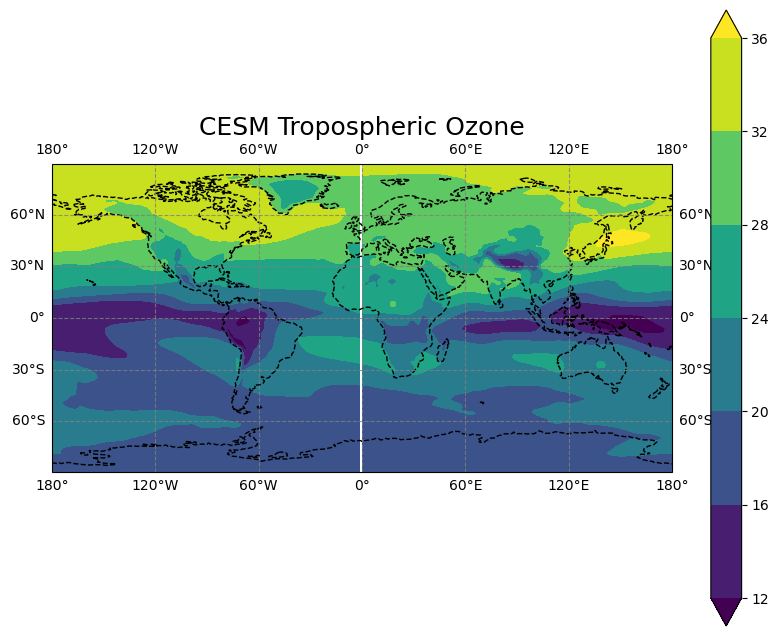

In [14]:
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

# add coastlines
ax.add_feature(cfeature.COASTLINE, linestyle='--')

# add lat lon grids
gl = ax.gridlines(draw_labels=True, color='grey', alpha=0.8, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

plt.title("CESM Tropospheric Ozone",fontsize=18)

# plotting data
plt.contourf(lon_cyclic, ozone_du_column_regridded.coords['lat'], ozone_cyclic, cmap='viridis', extend='both')

plt.colorbar()
plt.show()

In [15]:
difference = ozone_du_column_regridded - omi_mls_ds
difference[3]

<xarray.DataArray (lat: 180, lon: 360)> Size: 518kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    month    int64 8B 4
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5

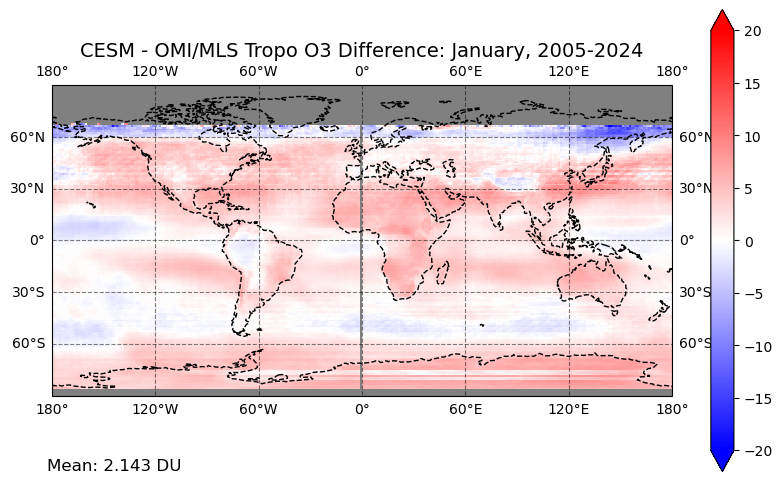

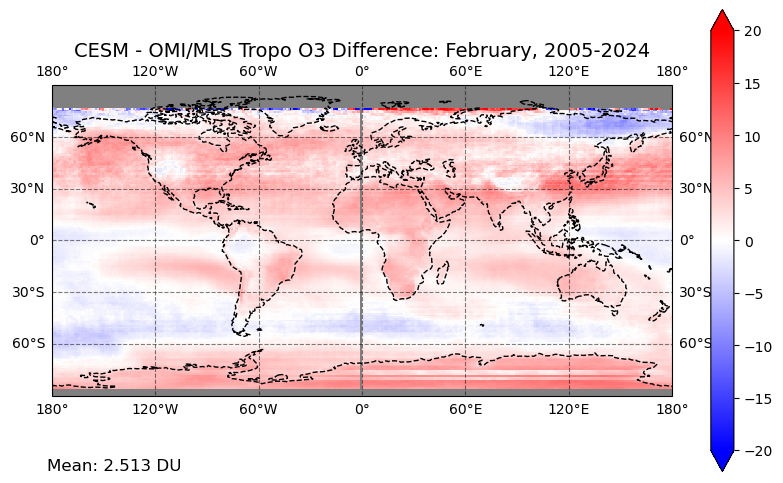

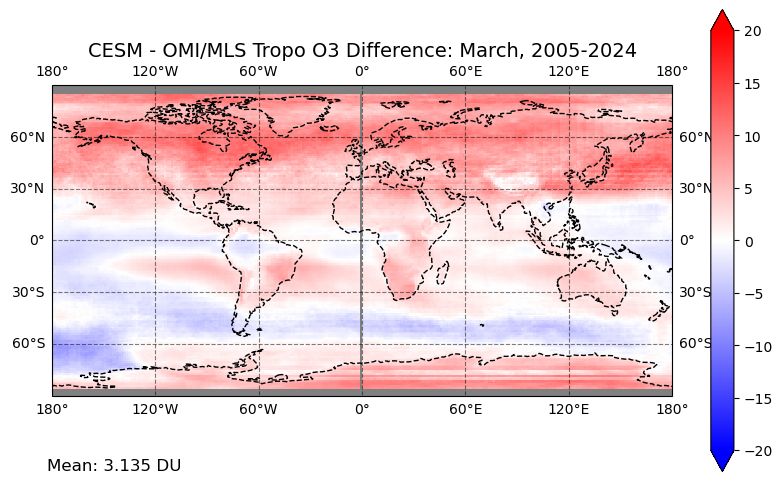

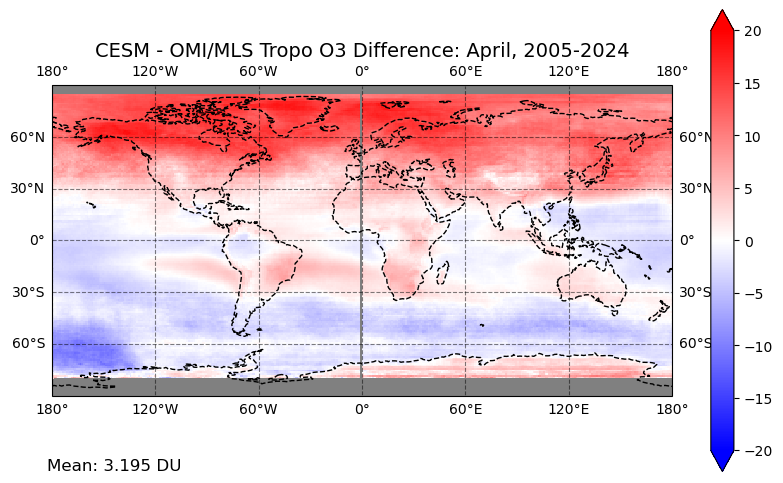

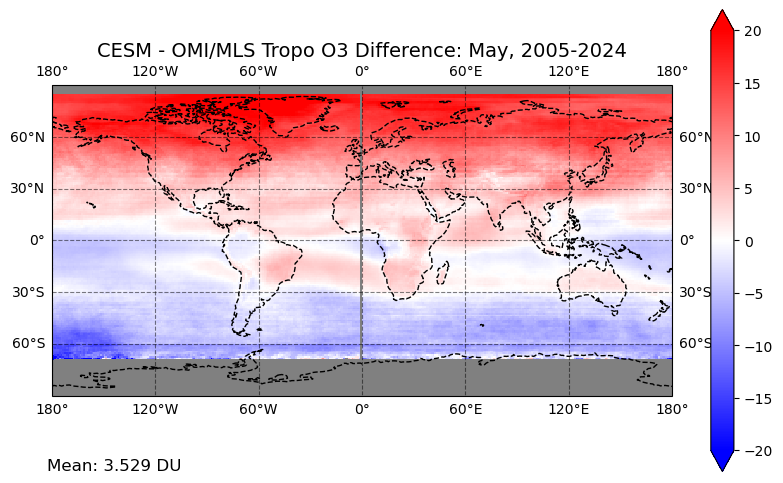

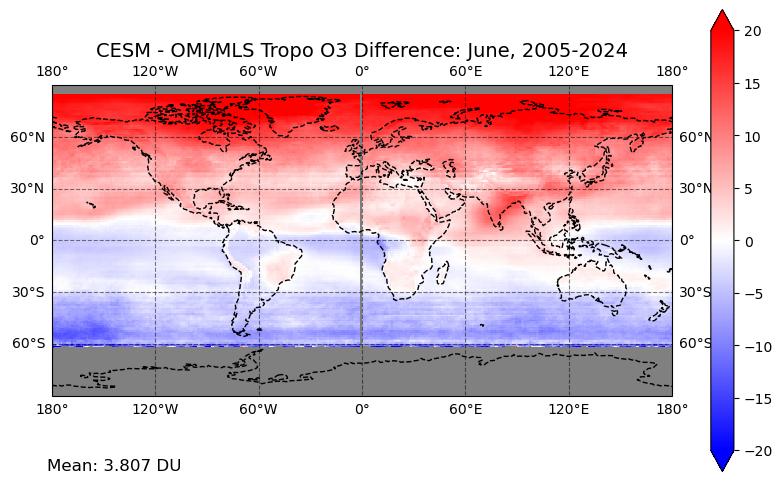

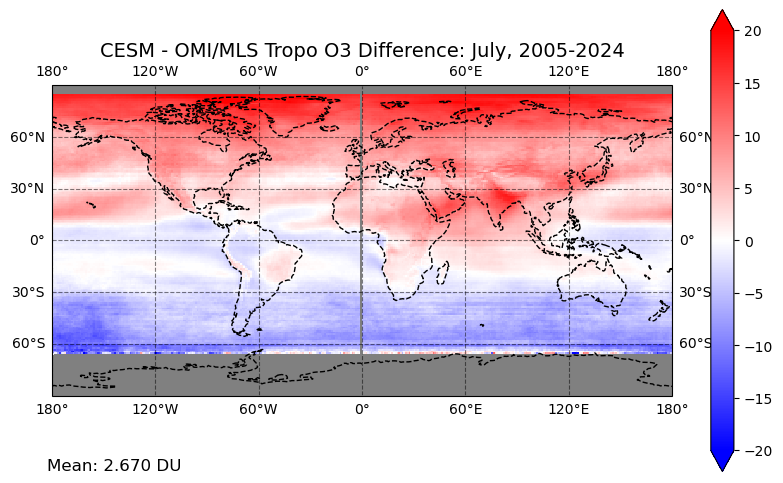

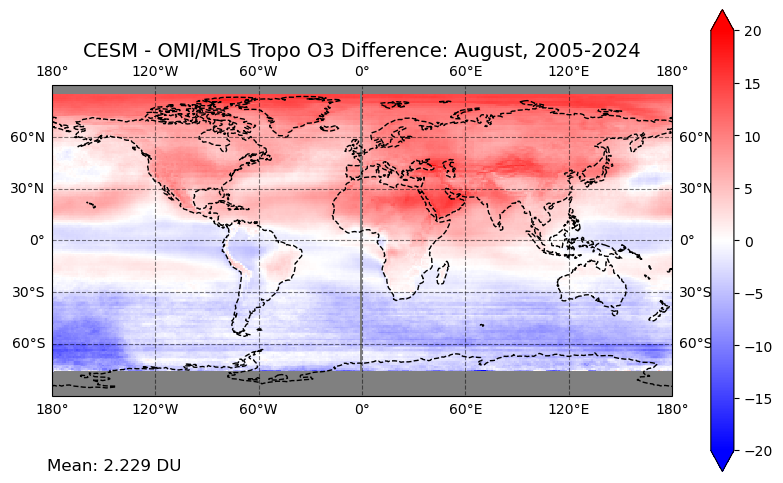

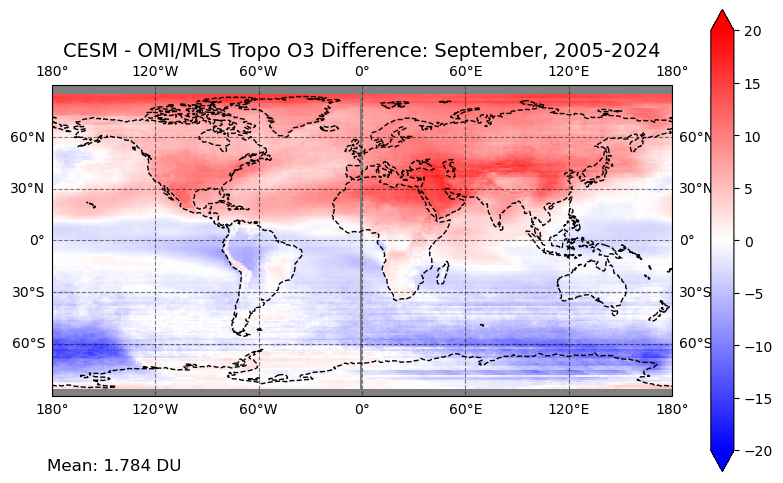

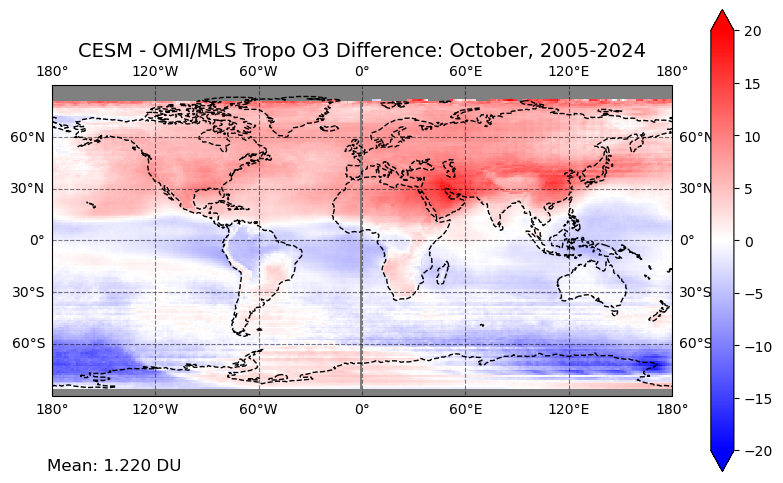

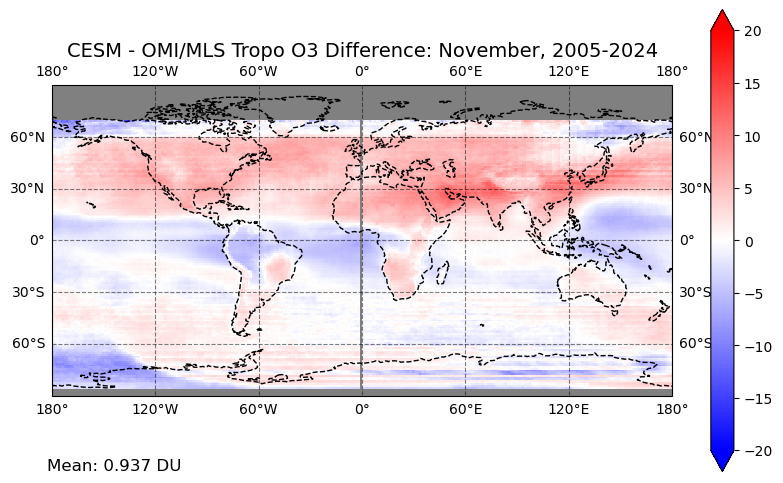

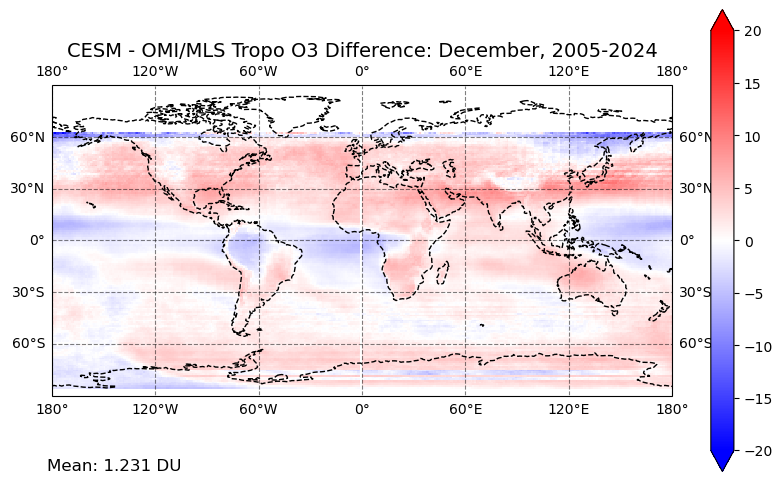

In [16]:
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'] # for cycling through figures to create a gif

i = 0
for i in range(12):
    
    plt.figure(figsize=(10, 6))
    ax.set_facecolor('gray')
    ax = plt.axes(projection=ccrs.PlateCarree())
    difference[i].plot(ax=ax,transform=ccrs.PlateCarree(central_longitude=0), vmin = -20, vmax = 20, extend='both', cmap='bwr')
    ax.add_feature(cfeature.COASTLINE, linestyle='--')
    ax.set_global()

    # adding gridlines
    ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
    ax.set_title("CESM - OMI/MLS Tropo O3 Difference: " + month_list[i] + ", 2005-2024", fontsize=14)
    
    formatted_mean = f"{difference[i].mean().data:.3f}"

    ax.text(0.10, -0.25, 'Mean: ' + str(formatted_mean) + ' DU', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12)
    

    #plt.savefig("figures/CESM_Diff-" + str(alphabet[i]))
    i+=1

    plt.show

In [17]:
import imageio
import os

def create_gif(image_folder, output_gif, duration):
    filenames = sorted([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
    images = []
    for filename in filenames:
        if filename.startswith("CESM_Diff"):
            image_path = os.path.join(image_folder, filename)
            images.append(imageio.imread(image_path))
    imageio.mimsave(output_gif, images, duration=duration)

image_dir = '/glade/u/home/mvoncyga/SOARS_2025/figures/'

#create_gif(image_dir, "Difference_Plot.gif", duration=1000)

In [18]:
difference

<xarray.DataArray (month: 12, lat: 180, lon: 360)> Size: 6MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5